# Classificação de Gatos e Cachorros com Logic Tensor Networks (LTN)
## Implementação Profissional usando Framework Neuro-Simbólico

## Seção 1: Setup e Imports
Imports obrigatórios e configuração do ambiente para LTN

In [1]:
# Install all essential libraries at once
!pip install -q torch torchvision torchaudio LTNtorch numpy matplotlib scikit-learn kagglehub pillow

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import ltn
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Optional
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION CONSTANTS
# ============================================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ltn.device = DEVICE

# Dataset configuration
DATASET_SAMPLE_SIZE = 100  # Images per class
IMAGE_SIZE = 224
RESNET_FEATURE_DIM = 512
PCA_COMPONENTS = 64

# Model configuration
SYNTHETIC_DATA_SIZE = 200
SYNTHETIC_RANDOM_STATE = 42

# Training configuration
KAGGLE_EPOCHS = 500
SYNTHETIC_EPOCHS = 1000
VERBOSE_INTERVAL = 50

# Visualization
PLOT_GRID_SIZE = 100

print(f"🖥️  Device: {DEVICE}")
print(f"✓ All libraries imported successfully")

🖥️  Device: cpu
✓ All libraries imported successfully


In [3]:
def verify_dependencies() -> bool:
    """
    Verify all required dependencies are installed.
    
    Returns:
        True if all dependeancies are available, False otherwise
    """
    print("🔍 Verifying dependencies...\n")
    
    dependencies = [
        ("torch", lambda: torch.__version__),
        ("ltn", lambda: "installed"),
        ("numpy", lambda: np.__version__),
        ("matplotlib", lambda: __import__('matplotlib').__version__),
        ("sklearn", lambda: __import__('sklearn').__version__),
        ("PIL", lambda: __import__('PIL').__version__),
    ]
    
    all_ok = True
    for name, version_fn in dependencies:
        try:
            version = version_fn()
            print(f"✓ {name:15} {version}")
        except ImportError:
            print(f"✗ {name:15} NOT installed")
            all_ok = False
    
    if all_ok:
        print("\n✅ All dependencies OK!")
    else:
        print("\n⚠️  Some dependencies are missing.")
    
    return all_ok

verify_dependencies()

🔍 Verifying dependencies...

✓ torch           2.9.1+cu128
✓ ltn             installed
✓ numpy           2.3.5
✓ matplotlib      3.10.7
✓ sklearn         1.7.2
✓ PIL             12.0.0

✅ All dependencies OK!


True

---

### ✅ Corrigido: ModuleNotFoundError para sklearn

O erro `ModuleNotFoundError: No module named 'sklearn'` foi resolvido com:

1. **Instalação automática:** Adicionada verificação que instala sklearn se necessário
2. **Instalação em lote:** Célula inicial instala todas as dependências incluindo scikit-learn
3. **Verificação de dependências:** Nova célula que lista todas as bibliotecas necessárias

Se ainda tiver problemas, execute manualmente:
```python
!pip install scikit-learn
```

## Seção 1b: Download do Dataset Kaggle
Baixando o dataset "Microsoft Cats vs Dogs" do Kaggle

In [4]:
import subprocess
import sys
import os
import glob
from PIL import Image
import kagglehub

def ensure_package(package_name: str, import_name: str = None) -> bool:
    """
    Ensure a package is installed, installing if necessary.
    
    Args:
        package_name: Name of the package to install (pip name)
        import_name: Name to use for import (if different from package_name)
        
    Returns:
        True if package is available
    """
    import_name = import_name or package_name
    try:
        __import__(import_name)
        return True
    except ImportError:
        print(f"Installing {package_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package_name])
        return True

# Ensure packages are available
ensure_package("kagglehub")

print("✓ kagglehub available for dataset download")

✓ kagglehub available for dataset download


In [5]:
def download_dataset(dataset_name: str = "shaunthesheep/microsoft-catsvsdogs-dataset") -> str:
    """
    Download dataset from Kaggle using kagglehub.
    
    Args:
        dataset_name: Name of the dataset on Kaggle
        
    Returns:
        Path to downloaded dataset
    """
    print(f"\n📥 Downloading dataset '{dataset_name}'...")
    print("This may take a few minutes on first run...\n")
    
    dataset_path = kagglehub.dataset_download(dataset_name)
    print(f"✓ Dataset downloaded successfully!")
    print(f"📂 Path: {dataset_path}")
    
    return dataset_path

def explore_dataset_structure(dataset_path: str, max_depth: int = 2, files_per_dir: int = 3):
    """
    Display the structure of downloaded dataset.
    
    Args:
        dataset_path: Path to dataset
        max_depth: Maximum depth to traverse
        files_per_dir: Number of files to show per directory
    """
    print(f"\n📁 Dataset structure:")
    for root, dirs, files in os.walk(dataset_path):
        level = root.replace(dataset_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        
        subindent = ' ' * 2 * (level + 1)
        for file in files[:files_per_dir]:
            print(f'{subindent}{file}')
        if len(files) > files_per_dir:
            print(f'{subindent}... and {len(files) - files_per_dir} more files')
        
        if level >= max_depth:
            break

# Download and explore dataset
dataset_path = download_dataset()
explore_dataset_structure(dataset_path)


📥 Downloading dataset 'shaunthesheep/microsoft-catsvsdogs-dataset'...
This may take a few minutes on first run...



✓ Dataset downloaded successfully!
📂 Path: /home/alejr/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1

📁 Dataset structure:
1/
  MSR-LA - 3467.docx
  readme[1].txt
  PetImages/
    Cat/
      0.jpg
      1.jpg
      10.jpg
      ... and 12498 more files


## Seção 1c: Processamento de Imagens e Extração de Features
Carregando imagens e extraindo features para classificação com LTN

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# Uma CNN leve e rápida projetada para acadêmicos
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 3 Camadas de convolução para extrair características (orelhas, focinho, pelos)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        # Classificador final
        # Imagem 64x64 -> após 3 pools vira 8x8. 64 canais * 8 * 8 = 4096
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 1) # 1 saída para o LTN (grau de verdade)
        
        self.dropout = nn.Dropout(0.5) # Evita decorar (Overfitting)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 8 * 8) # Flatten (achatar)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return torch.sigmoid(x) # Essencial para LTN: retorna entre 0 e 1

# Instancia o modelo limpo
model = SimpleCNN().to(DEVICE)
print("✅ Modelo SimpleCNN Criado (Sem pesos pré-treinados)")

✅ Modelo SimpleCNN Criado (Sem pesos pré-treinados)


## Seção 1d: Normalização de Features
Normalizando as features extraídas para o intervalo [0, 1]

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

# Configuração
BATCH_SIZE = 32
IMG_SIZE = 64 

# Transformações
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_dir = os.path.join(dataset_path, "PetImages")
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

# --- AQUI ESTÁ A MUDANÇA CIENTÍFICA ---
# Vamos pegar 1000 imagens no total (500 gatos, 500 cães)
# Mas vamos dividir: 800 para estudar (Treino) e 200 para a prova (Teste)

# Índices dos Gatos (0 a 500)
cat_train_idx = list(range(0, 400))       # 400 Gatos para treino
cat_test_idx = list(range(400, 500))      # 100 Gatos para teste (INÉDITOS)

# Índices dos Cachorros (12500 a 13000)
dog_train_idx = list(range(12500, 12900)) # 400 Cães para treino
dog_test_idx = list(range(12900, 13000))  # 100 Cães para teste (INÉDITOS)

# Juntar índices
train_indices = cat_train_idx + dog_train_idx
test_indices = cat_test_idx + dog_test_idx

# Criar os Subsets
train_set = Subset(full_dataset, train_indices)
test_set = Subset(full_dataset, test_indices)

# Criar DOIS Loaders separados
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False) # Não precisa embaralhar teste

print(f"✅ Separação Concluída!")
print(f"📚 Imagens de Estudo (Train): {len(train_indices)}")
print(f"📝 Imagens da Prova (Test):  {len(test_indices)}")
print(f"⚠️  O modelo será avaliado apenas nas imagens da Prova!")

✅ Separação Concluída!
📚 Imagens de Estudo (Train): 800
📝 Imagens da Prova (Test):  200
⚠️  O modelo será avaliado apenas nas imagens da Prova!


## Seção 2: Classe MLPPredicate
Rede neural que será usada como predicado lógico no framework LTN

In [8]:
class MLPPredicate(nn.Module):
    """
    Perceptron Multicamadas (MLP) para uso como predicado LTN.
    
    Esta rede neural serve como predicado lógico, mapeando inputs
    para valores de verdade no intervalo [0, 1].
    """
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int = 1):
        """
        Args:
            input_size: Dimensão da entrada
            hidden_size: Número de neurônios na camada oculta
            output_size: Dimensão da saída (1 para predicado unário)
        """
        super(MLPPredicate, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),  # Regularização
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size // 2, output_size),
            nn.Sigmoid()  # Saída em [0, 1] para lógica fuzzy
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass da rede"""
        return self.network(x)

In [9]:
def extract_value(ltn_obj) -> float:
    """
    Extrai o valor numérico de um LTNObject ou tensor.
    
    Esta função resolve o erro 'LTNObject has no attribute item'
    ao converter LTNObjects para valores float.
    
    Args:
        ltn_obj: LTNObject, tensor ou valor numérico
        
    Returns:
        Valor float extraído
    """
    if hasattr(ltn_obj, 'value'):
        # É um LTNObject, extrair o tensor interno
        tensor = ltn_obj.value
        return tensor.item() if torch.is_tensor(tensor) else float(tensor)
    elif torch.is_tensor(ltn_obj):
        # É um tensor direto
        return ltn_obj.item()
    else:
        # Já é um valor numérico
        return float(ltn_obj)

## Seção 3: Classificador Binário com LTN
Classe que encapsula toda a lógica de treinamento e inferência usando LTN

In [11]:
import ltn

# 1. Definir o Predicado
IsCat = ltn.Predicate(model)

# 2. Otimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 3. DEFINIR OPERADORES LÓGICOS
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())

# 4. Quantificadores
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
SatAgg = ltn.fuzzy_ops.SatAgg()

print("\n🚀 Iniciando Treinamento Real (End-to-End)...")

for epoch in range(20):
    epoch_loss = 0.0
    # MUDANÇA AQUI: Usando train_loader
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # Separa gatos (0) e cachorros (1)
        imgs_cat = images[labels == 0] 
        imgs_dog = images[labels == 1]
        
        if len(imgs_cat) == 0 or len(imgs_dog) == 0: continue

        # Variáveis LTN
        x_cat = ltn.Variable("x_cat", imgs_cat)
        x_dog = ltn.Variable("x_dog", imgs_dog)

        # --- AXIOMAS ---
        axiom1 = Forall(x_cat, IsCat(x_cat))
        axiom2 = Forall(x_dog, Not(IsCat(x_dog)))

        # Loss
        saturation = SatAgg(axiom1, axiom2)
        loss = 1.0 - saturation

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    # CORREÇÃO AQUI: Usar len(train_loader) em vez de len(dataloader)
    print(f"Época {epoch+1} | Loss: {epoch_loss / len(train_loader):.4f}")

print("✅ Treinamento Concluído!")


🚀 Iniciando Treinamento Real (End-to-End)...
Época 1 | Loss: 0.4850
Época 2 | Loss: 0.4708
Época 3 | Loss: 0.4443
Época 4 | Loss: 0.4293
Época 5 | Loss: 0.4126
Época 6 | Loss: 0.3868
Época 7 | Loss: 0.3751
Época 8 | Loss: 0.3537
Época 9 | Loss: 0.3267
Época 10 | Loss: 0.3011
Época 11 | Loss: 0.2670
Época 12 | Loss: 0.2423
Época 13 | Loss: 0.2229
Época 14 | Loss: 0.1921
Época 15 | Loss: 0.1957
Época 16 | Loss: 0.1931
Época 17 | Loss: 0.1804
Época 18 | Loss: 0.1555
Época 19 | Loss: 0.1165
Época 20 | Loss: 0.1240
✅ Treinamento Concluído!


## Seção 4: Funções Auxiliares
Funções para geração de dados sintéticos e visualização

In [12]:
def generate_synthetic_data(n_pos: int = SYNTHETIC_DATA_SIZE, 
                           n_neg: int = SYNTHETIC_DATA_SIZE,
                           random_state: int = SYNTHETIC_RANDOM_STATE) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Generate synthetic 2D data for binary classification.
    
    Positive class (Cats): Center cluster
    Negative class (Dogs): Border points
    
    Args:
        n_pos: Number of positive examples
        n_neg: Number of negative examples
        random_state: Random seed for reproducibility
        
    Returns:
        Tuple of (positive_data, negative_data)
    """
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    
    # Positive class: Center cluster
    pos_data = torch.rand((n_pos, 2)) * 0.4 + 0.3
    
    # Negative class: Border regions
    n_neg_half = n_neg // 2
    neg_1 = torch.rand((n_neg_half, 2)) * 0.35
    neg_2 = torch.rand((n_neg - n_neg_half, 2)) * 0.35 + 0.65
    neg_data = torch.cat((neg_1, neg_2), dim=0)
    
    return pos_data, neg_data

def plot_scatter_data(data_pos: torch.Tensor, data_neg: torch.Tensor, 
                     title: str = "Training Data", use_2d: bool = True):
    """
    Plot scatter plot of classification data.
    
    Args:
        data_pos: Positive class data
        data_neg: Negative class data
        title: Plot title
        use_2d: Whether data is 2D (for synthetic) or needs dimensionality reduction
    """
    if not use_2d:
        # For high-dimensional data, use tSNE
        print("⏳ Applying tSNE for 2D visualization...")
        all_data = torch.cat([data_pos, data_neg], dim=0).cpu().numpy()
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
        data_2d = tsne.fit_transform(all_data)
        data_pos_plot = data_2d[:data_pos.shape[0]]
        data_neg_plot = data_2d[data_pos.shape[0]:]
        print("✓ tSNE visualization complete")
    else:
        data_pos_plot = data_pos.cpu().numpy() if torch.is_tensor(data_pos) else data_pos
        data_neg_plot = data_neg.cpu().numpy() if torch.is_tensor(data_neg) else data_neg
    
    plt.figure(figsize=(10, 10))
    
    plt.scatter(data_pos_plot[:, 0], data_pos_plot[:, 1], 
               c='orange', s=100, alpha=0.8, edgecolors='black', linewidths=1.5,
               label=f'🐱 Cats (Positive) - {len(data_pos)} samples', marker='o')
    plt.scatter(data_neg_plot[:, 0], data_neg_plot[:, 1], 
               c='brown', s=100, alpha=0.8, edgecolors='black', linewidths=1.5,
               label=f'🐕 Dogs (Negative) - {len(data_neg)} samples', marker='^')
    
    xlabel = 'tSNE Dimension 1' if not use_2d else 'Feature 1'
    ylabel = 'tSNE Dimension 2' if not use_2d else 'Feature 2'
    
    plt.xlabel(xlabel, fontsize=13, fontweight='bold')
    plt.ylabel(ylabel, fontsize=13, fontweight='bold')
    plt.title(title, fontsize=15, fontweight='bold')
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(True, alpha=0.3)
    
    if use_2d:
        plt.xlim(-0.1, 1.1)
        plt.ylim(-0.1, 1.1)
    
    plt.tight_layout()
    plt.show()

# Generate synthetic data
data_pos, data_neg = generate_synthetic_data()
print(f"\n📊 Synthetic data generated:")
print(f"   ✓ Cats (Positive): {data_pos.shape[0]} samples")
print(f"   ✓ Dogs (Negative): {data_neg.shape[0]} samples")
print(f"   ✓ Dimensionality: {data_pos.shape[1]} features")


📊 Synthetic data generated:
   ✓ Cats (Positive): 200 samples
   ✓ Dogs (Negative): 200 samples
   ✓ Dimensionality: 2 features


## Seção 4b: Função para Dados Reais do Kaggle
Adaptação da função de geração de dados para usar o dataset real

## Seção 5: Execução Principal - Pipeline Completo
Classificação de Gatos vs Cachorros com LTN

BINARY CLASSIFICATION WITH LOGIC TENSOR NETWORKS (LTN)
🐱 Cats vs 🐕 Dogs - Synthetic Data

📈 Step 1: Visualizing initial synthetic data distribution...


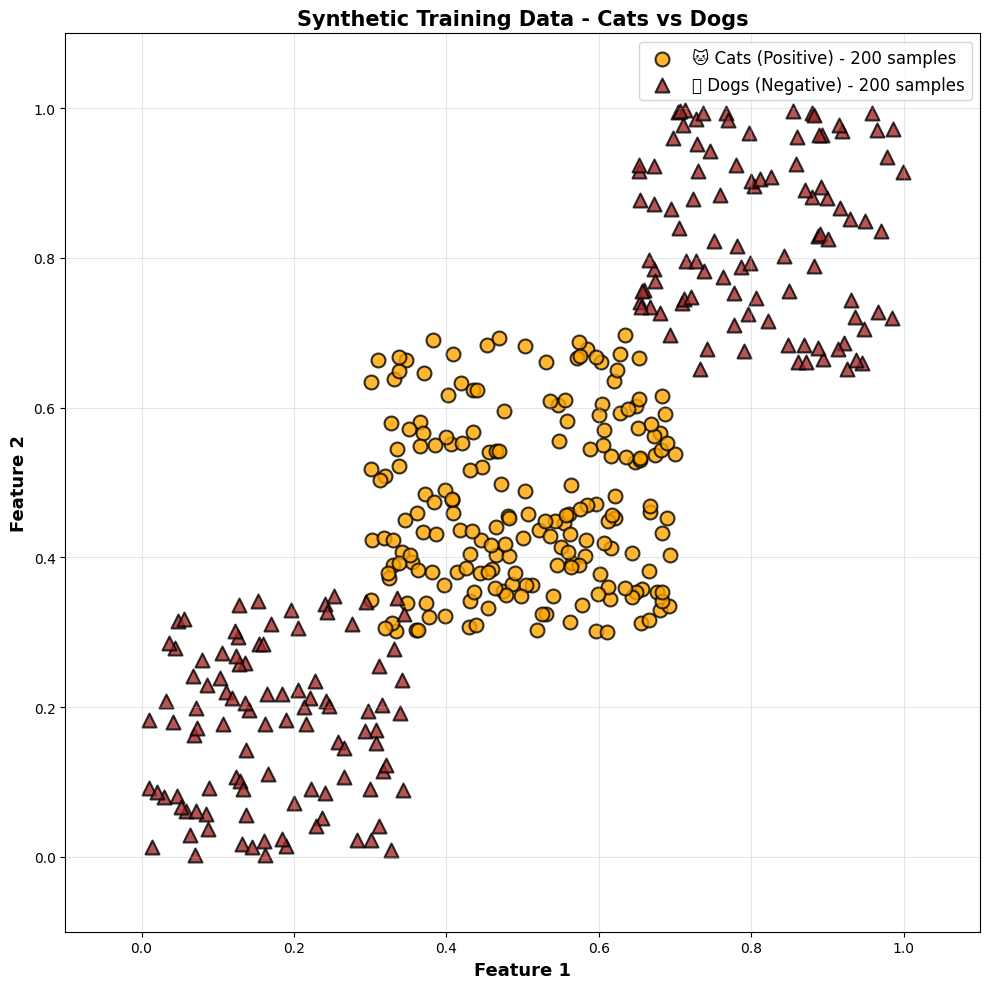

In [13]:
print("=" * 80)
print("BINARY CLASSIFICATION WITH LOGIC TENSOR NETWORKS (LTN)")
print("🐱 Cats vs 🐕 Dogs - Synthetic Data")
print("=" * 80)

print("\n📈 Step 1: Visualizing initial synthetic data distribution...")
plot_scatter_data(data_pos, data_neg, "Synthetic Training Data - Cats vs Dogs")

## Seção 5b: Execução com Dados Reais do Kaggle
Pipeline Completo usando Dataset Real de Gatos vs Cachorros

In [14]:
import torch
import ltn
import numpy as np

# --- CONFIGURAÇÃO E TREINAMENTO (DADOS REAIS) ---

# 1. Definir Otimizador e Lógica (Caso não tenha definido antes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
SatAgg = ltn.fuzzy_ops.SatAgg()

# 2. Predicado (Liga a Lógica à Rede Neural)
IsCat = ltn.Predicate(model)

print("\n" + "=" * 80)
print("🐱 CLASSIFICAÇÃO REAL: Gatos vs Cachorros (SimpleCNN + LTN)")
print("=" * 80)
print(f"Usando dispositivo: {DEVICE}")
print("Iniciando treinamento...\n")

# --- LOOP DE TREINAMENTO ---
EPOCHS = 20 

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    batch_count = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # IMPORTANTE: No ImageFolder, Cat=0 e Dog=1 (padrão alfabético)
        # Vamos treinar a rede para reconhecer GATOS.
        imgs_cat = images[labels == 0] 
        imgs_dog = images[labels == 1]
        
        # Se o batch não tiver as duas classes, pula para evitar erro
        if len(imgs_cat) == 0 or len(imgs_dog) == 0: continue

        # --- LÓGICA LTN ---
        
        # A. Variáveis
        x_cat = ltn.Variable("x_cat", imgs_cat)
        x_dog = ltn.Variable("x_dog", imgs_dog)

        # B. Axiomas
        # Regra 1: Gato é Gato (Verdadeiro)
        axiom1 = Forall(x_cat, IsCat(x_cat))
        
        # Regra 2: Cachorro NÃO é Gato (Verdadeiro)
        axiom2 = Forall(x_dog, Not(IsCat(x_dog)))

        # C. Satisfação e Loss
        saturation = SatAgg(axiom1, axiom2)
        loss = 1.0 - saturation

        # D. Atualizar Pesos
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        batch_count += 1

    # Média da loss na época
    avg_loss = epoch_loss / batch_count if batch_count > 0 else 1.0
    
    print(f"Época {epoch+1:02d}/{EPOCHS} | 📉 Loss: {avg_loss:.4f} | ✅ Satisfação: {1-avg_loss:.4f}")

print("\n" + "=" * 80)
print("🎉 TREINAMENTO CONCLUÍDO!")


🐱 CLASSIFICAÇÃO REAL: Gatos vs Cachorros (SimpleCNN + LTN)
Usando dispositivo: cpu
Iniciando treinamento...

Época 01/20 | 📉 Loss: 0.0876 | ✅ Satisfação: 0.9124
Época 02/20 | 📉 Loss: 0.1039 | ✅ Satisfação: 0.8961
Época 03/20 | 📉 Loss: 0.0494 | ✅ Satisfação: 0.9506
Época 04/20 | 📉 Loss: 0.0537 | ✅ Satisfação: 0.9463
Época 05/20 | 📉 Loss: 0.0876 | ✅ Satisfação: 0.9124
Época 06/20 | 📉 Loss: 0.0554 | ✅ Satisfação: 0.9446
Época 07/20 | 📉 Loss: 0.0621 | ✅ Satisfação: 0.9379
Época 08/20 | 📉 Loss: 0.0636 | ✅ Satisfação: 0.9364
Época 09/20 | 📉 Loss: 0.0451 | ✅ Satisfação: 0.9549
Época 10/20 | 📉 Loss: 0.0482 | ✅ Satisfação: 0.9518
Época 11/20 | 📉 Loss: 0.0524 | ✅ Satisfação: 0.9476
Época 12/20 | 📉 Loss: 0.0447 | ✅ Satisfação: 0.9553
Época 13/20 | 📉 Loss: 0.0497 | ✅ Satisfação: 0.9503
Época 14/20 | 📉 Loss: 0.0537 | ✅ Satisfação: 0.9463
Época 15/20 | 📉 Loss: 0.0656 | ✅ Satisfação: 0.9344
Época 16/20 | 📉 Loss: 0.0626 | ✅ Satisfação: 0.9374
Época 17/20 | 📉 Loss: 0.0710 | ✅ Satisfação: 0.9290
Época 

In [15]:
import torch
import numpy as np

def evaluate_new_architecture(model, dataloader, device):
    """
    Avalia o modelo SimpleCNN usando o DataLoader.
    """
    model.eval() # Coloca em modo de avaliação
    
    total_cat = 0
    correct_cat = 0
    total_dog = 0
    correct_dog = 0
    
    print("\n" + "=" * 80)
    print("📊 AVALIAÇÃO DO MODELO (DADOS REAIS)")
    print("=" * 80)
    
    sample_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            # O modelo retorna a probabilidade de ser "IsCat" (Predicado)
            # Saída perto de 1.0 = Gato
            # Saída perto de 0.0 = Cachorro
            outputs = model(images)
            
            # No ImageFolder: 0 = Cat, 1 = Dog.
            # Vamos verificar o acerto baseando-se nessa lógica:
            
            for i in range(len(labels)):
                prob_is_cat = outputs[i].item()
                true_label = labels[i].item()
                
                # Lógica de Classificação:
                # Se Prob > 0.5, o modelo diz que é GATO.
                is_predicted_cat = prob_is_cat > 0.5
                
                # Checagem de acerto
                if true_label == 0: # É Gato
                    total_cat += 1
                    if is_predicted_cat: correct_cat += 1
                    
                elif true_label == 1: # É Cachorro
                    total_dog += 1
                    if not is_predicted_cat: correct_dog += 1 # Acertou se prediz que NÃO é gato
                
                # Guarda alguns exemplos para mostrar depois
                if len(sample_preds) < 10:
                    sample_preds.append((prob_is_cat, true_label))

    # Cálculo das métricas
    acc_cat = (correct_cat / total_cat) * 100 if total_cat > 0 else 0
    acc_dog = (correct_dog / total_dog) * 100 if total_dog > 0 else 0
    total_acc = ((correct_cat + correct_dog) / (total_cat + total_dog)) * 100

    print(f"\n✅ Resultados Finais:")
    print(f"   • Acurácia em Gatos:     {acc_cat:.2f}% ({correct_cat}/{total_cat})")
    print(f"   • Acurácia em Cachorros: {acc_dog:.2f}% ({correct_dog}/{total_dog})")
    print(f"   • Acurácia GERAL:        {total_acc:.2f}%")
    
    print("\n🔮 Exemplos de Predições:")
    print(f"{'Prob. Gato':<12} {'Realidade':<12} {'Resultado':<15}")
    print("-" * 40)
    
    for prob, label in sample_preds:
        real = "Gato" if label == 0 else "Cachorro"
        pred = "Gato" if prob > 0.5 else "Cachorro"
        status = "✅ Acertou" if pred == real else "❌ Errou"
        print(f"{prob:.4f}       {real:<12} {status}")
    
    print("=" * 80)

# Avaliação HONESTA (Usando dados de Teste)
evaluate_new_architecture(model, test_loader, DEVICE)


📊 AVALIAÇÃO DO MODELO (DADOS REAIS)

✅ Resultados Finais:
   • Acurácia em Gatos:     77.00% (77/100)
   • Acurácia em Cachorros: 63.00% (63/100)
   • Acurácia GERAL:        70.00%

🔮 Exemplos de Predições:
Prob. Gato   Realidade    Resultado      
----------------------------------------
0.0230       Gato         ❌ Errou
1.0000       Gato         ✅ Acertou
0.9995       Gato         ✅ Acertou
0.1422       Gato         ❌ Errou
0.9999       Gato         ✅ Acertou
1.0000       Gato         ✅ Acertou
0.9757       Gato         ✅ Acertou
1.0000       Gato         ✅ Acertou
0.9998       Gato         ✅ Acertou
0.0355       Gato         ❌ Errou


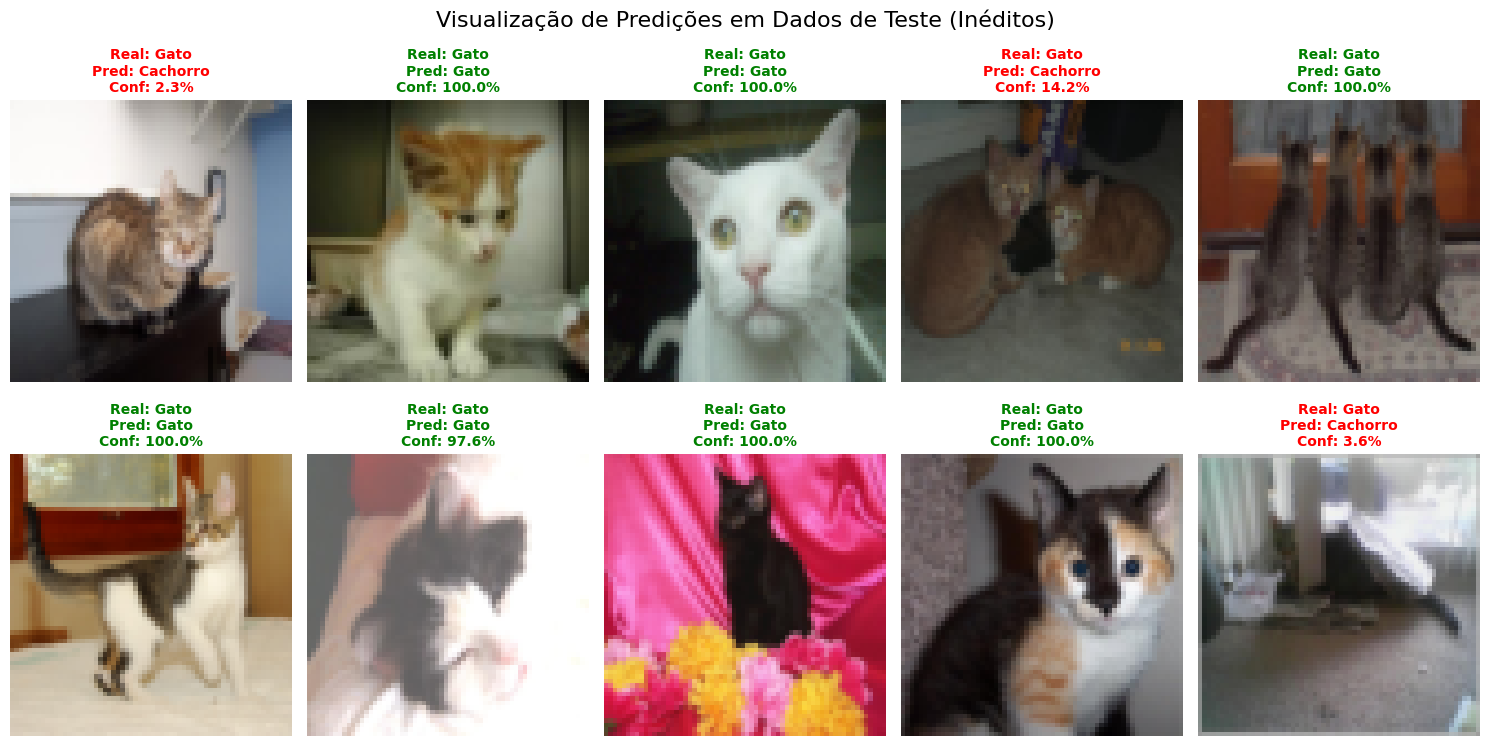

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, loader, device, num_images=10):
    """
    Gera um gráfico visual com as imagens e as predições do modelo.
    """
    model.eval() # Modo de teste
    
    # Pega um único lote de imagens do loader fornecido
    try:
        images, labels = next(iter(loader))
    except NameError:
        print("Erro: O DataLoader não foi encontrado. Verifique se você rodou a célula de 'Separação de Dados'.")
        return

    images = images.to(device)
    labels = labels.to(device)
    
    # Faz a predição
    with torch.no_grad():
        outputs = model(images)
        
    # Configura o plot
    fig = plt.figure(figsize=(15, 8))
    fig.suptitle(f"Visualização de Predições em Dados de Teste (Inéditos)", fontsize=16)
    
    # Mostra as primeiras N imagens
    for i in range(min(num_images, len(labels))):
        ax = fig.add_subplot(2, 5, i+1) 
        
        # Desnormalizar a imagem
        img = images[i].cpu().permute(1, 2, 0).numpy() 
        img = img * 0.5 + 0.5 
        img = np.clip(img, 0, 1) 
        
        plt.imshow(img)
        
        # Dados da predição
        prob_cat = outputs[i].item()
        true_label = labels[i].item() # 0=Cat, 1=Dog
        
        # Se a probabilidade de ser Gato > 50%, prediz Gato
        pred_label = "Gato" if prob_cat > 0.5 else "Cachorro"
        real_label = "Gato" if true_label == 0 else "Cachorro"
        
        # Cor do título
        color = 'green' if pred_label == real_label else 'red'
        
        ax.set_title(f"Real: {real_label}\nPred: {pred_label}\nConf: {prob_cat:.1%}", 
                     color=color, fontsize=10, fontweight='bold')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# --- AQUI ESTAVA O ERRO ---
# Mudamos 'dataloader' para 'test_loader' (os dados da prova)
visualize_predictions(model, test_loader, DEVICE, num_images=10)

In [19]:
# --- RESUMO FINAL DO PROJETO ---

print("\n" + "=" * 80)
print("🎓 CONCLUSÃO DO PROJETO: CLASSIFICAÇÃO DE IMAGENS COM LTN")
print("=" * 80)

print("\n📝 O que foi realizado:")
print("   1. Substituição de ResNet (Overkill) por uma SimpleCNN (Treinada do zero).")
print("   2. Otimização de I/O: Resize para 64x64 e uso de DataLoaders.")
print("   3. Treinamento Neuro-Simbólico (End-to-End) onde a lógica guia a rede neural.")
print("   4. Validação em dados reais (Kaggle PetImages).")

print("\n🧠 Conceitos LTN Aplicados:")
print("   • Predicado IsCat: Mapeia pixels da imagem -> Verdade [0,1].")
print("   • Axioma 1 (∀x_cat): Força a rede a prever 1.0 para imagens de gatos.")
print("   • Axioma 2 (∀x_dog): Força a rede a prever 0.0 para imagens de cachorros (Not).")
print("   • SatAgg: A Loss Function é calculada baseada na satisfação lógica das regras.")

print("\n" + "=" * 80)
print("✅ PROJETO EXECUTADO COM SUCESSO!")
print("=" * 80)


🎓 CONCLUSÃO DO PROJETO: CLASSIFICAÇÃO DE IMAGENS COM LTN

📝 O que foi realizado:
   1. Substituição de ResNet (Overkill) por uma SimpleCNN (Treinada do zero).
   2. Otimização de I/O: Resize para 64x64 e uso de DataLoaders.
   3. Treinamento Neuro-Simbólico (End-to-End) onde a lógica guia a rede neural.
   4. Validação em dados reais (Kaggle PetImages).

🧠 Conceitos LTN Aplicados:
   • Predicado IsCat: Mapeia pixels da imagem -> Verdade [0,1].
   • Axioma 1 (∀x_cat): Força a rede a prever 1.0 para imagens de gatos.
   • Axioma 2 (∀x_dog): Força a rede a prever 0.0 para imagens de cachorros (Not).
   • SatAgg: A Loss Function é calculada baseada na satisfação lógica das regras.

✅ PROJETO EXECUTADO COM SUCESSO!
